In [1]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec


warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [135]:
#########################
############ Hyperparamter
#########################

st_dev = 0.1
learning_rate = 0.045
training_iters = 5000000
batch_size = 128
display_step = 100

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 8 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [129]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [136]:
tf.reset_default_graph()

tf.set_random_seed(0.5)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
#keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev, seed=0.5))
}

b = {
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [137]:
def RNN(x, W, b):

    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, state_is_tuple = True)
        
    # Get lstm cell output
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']

In [138]:

pred = RNN(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [139]:
# Launch the graph
with tf.Session() as sess:

    sess.run(init)
    step = 1
    losses = {'train':[], 'validation':[]}
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        offset_test = (step * batch_size) % (y_test.shape[0] - batch_size)
        
        # Generate minibatches for training and validating.
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        batch_test_x = x_test[offset_test:(offset_test + batch_size), :]
        batch_test_y = y_test[offset_test:(offset_test + batch_size), :]
        
        # Reshape data to feed into RNN
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        batch_test_x = batch_test_x.reshape((batch_size, n_steps, n_input))
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        loss_test = sess.run(cost, feed_dict={x: batch_test_x, y: batch_test_y})

        if step % display_step == 0:

            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Accuracy= " + \
                  "{:.6f}".format(loss)
                        
        losses['train'].append(loss)
        losses['validation'].append(loss_test)
        step += 1
            
    print("Optimization Finished!")

    # Generate confusion matrix for metrics computation
    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input))})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)
    
    

Iter 12800, Minibatch Loss= 2.281091, Minibatch Val Accuracy= 2.281091
Iter 25600, Minibatch Loss= 0.013877, Minibatch Val Accuracy= 0.013877
Iter 38400, Minibatch Loss= 0.002595, Minibatch Val Accuracy= 0.002595
Iter 51200, Minibatch Loss= 0.021455, Minibatch Val Accuracy= 0.021455
Iter 64000, Minibatch Loss= 0.003877, Minibatch Val Accuracy= 0.003877
Iter 76800, Minibatch Loss= 0.098559, Minibatch Val Accuracy= 0.098559
Iter 89600, Minibatch Loss= 0.028971, Minibatch Val Accuracy= 0.028971
Iter 102400, Minibatch Loss= 0.013408, Minibatch Val Accuracy= 0.013408
Iter 115200, Minibatch Loss= 0.002818, Minibatch Val Accuracy= 0.002818
Iter 128000, Minibatch Loss= 0.001546, Minibatch Val Accuracy= 0.001546
Iter 140800, Minibatch Loss= 3.316744, Minibatch Val Accuracy= 3.316744
Iter 153600, Minibatch Loss= 0.027596, Minibatch Val Accuracy= 0.027596
Iter 166400, Minibatch Loss= 0.002965, Minibatch Val Accuracy= 0.002965
Iter 179200, Minibatch Loss= 0.002033, Minibatch Val Accuracy= 0.002033

Iter 1472000, Minibatch Loss= 0.009280, Minibatch Val Accuracy= 0.009280
Iter 1484800, Minibatch Loss= 0.004329, Minibatch Val Accuracy= 0.004329
Iter 1497600, Minibatch Loss= 0.002542, Minibatch Val Accuracy= 0.002542
Iter 1510400, Minibatch Loss= 0.003321, Minibatch Val Accuracy= 0.003321
Iter 1523200, Minibatch Loss= 0.946130, Minibatch Val Accuracy= 0.946130
Iter 1536000, Minibatch Loss= 0.000010, Minibatch Val Accuracy= 0.000010
Iter 1548800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 1561600, Minibatch Loss= 0.026280, Minibatch Val Accuracy= 0.026280
Iter 1574400, Minibatch Loss= 0.099280, Minibatch Val Accuracy= 0.099280
Iter 1587200, Minibatch Loss= 0.034645, Minibatch Val Accuracy= 0.034645
Iter 1600000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 1612800, Minibatch Loss= 0.000049, Minibatch Val Accuracy= 0.000049
Iter 1625600, Minibatch Loss= 0.221349, Minibatch Val Accuracy= 0.221349
Iter 1638400, Minibatch Loss= 0.000160, Minibatch V

Iter 2918400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 2931200, Minibatch Loss= 0.000376, Minibatch Val Accuracy= 0.000376
Iter 2944000, Minibatch Loss= 0.000008, Minibatch Val Accuracy= 0.000008
Iter 2956800, Minibatch Loss= 0.771328, Minibatch Val Accuracy= 0.771328
Iter 2969600, Minibatch Loss= 0.001275, Minibatch Val Accuracy= 0.001275
Iter 2982400, Minibatch Loss= 0.001525, Minibatch Val Accuracy= 0.001525
Iter 2995200, Minibatch Loss= 0.006419, Minibatch Val Accuracy= 0.006419
Iter 3008000, Minibatch Loss= 0.000022, Minibatch Val Accuracy= 0.000022
Iter 3020800, Minibatch Loss= 0.000136, Minibatch Val Accuracy= 0.000136
Iter 3033600, Minibatch Loss= 0.000133, Minibatch Val Accuracy= 0.000133
Iter 3046400, Minibatch Loss= 0.010811, Minibatch Val Accuracy= 0.010811
Iter 3059200, Minibatch Loss= 0.000134, Minibatch Val Accuracy= 0.000134
Iter 3072000, Minibatch Loss= 0.022698, Minibatch Val Accuracy= 0.022698
Iter 3084800, Minibatch Loss= 0.000015, Minibatch V

Iter 4364800, Minibatch Loss= 0.000313, Minibatch Val Accuracy= 0.000313
Iter 4377600, Minibatch Loss= 0.000277, Minibatch Val Accuracy= 0.000277
Iter 4390400, Minibatch Loss= 0.000248, Minibatch Val Accuracy= 0.000248
Iter 4403200, Minibatch Loss= 0.007457, Minibatch Val Accuracy= 0.007457
Iter 4416000, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000001
Iter 4428800, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000001
Iter 4441600, Minibatch Loss= 0.000012, Minibatch Val Accuracy= 0.000012
Iter 4454400, Minibatch Loss= 0.000030, Minibatch Val Accuracy= 0.000030
Iter 4467200, Minibatch Loss= 0.001332, Minibatch Val Accuracy= 0.001332
Iter 4480000, Minibatch Loss= 0.003076, Minibatch Val Accuracy= 0.003076
Iter 4492800, Minibatch Loss= 0.000235, Minibatch Val Accuracy= 0.000235
Iter 4505600, Minibatch Loss= 0.000018, Minibatch Val Accuracy= 0.000018
Iter 4518400, Minibatch Loss= 0.000006, Minibatch Val Accuracy= 0.000006
Iter 4531200, Minibatch Loss= 0.167414, Minibatch V

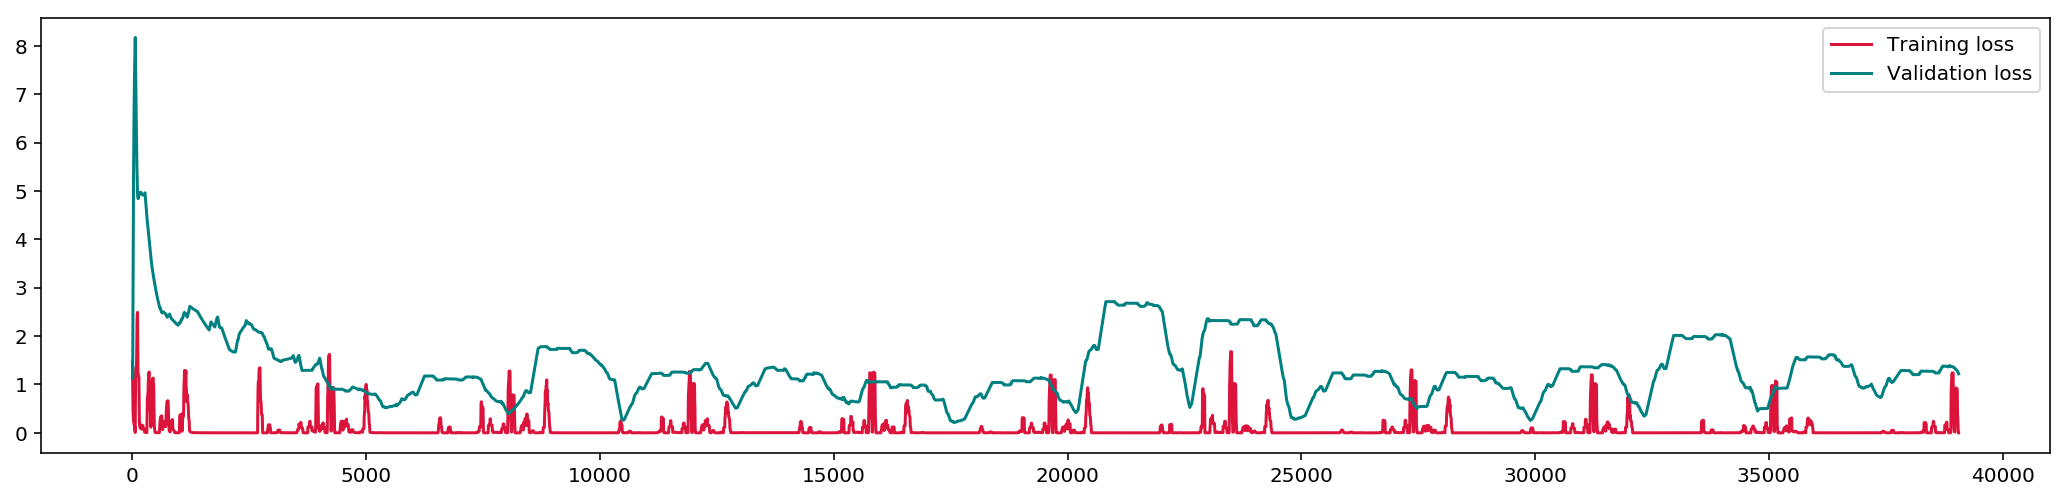

In [140]:

smoothed_loss = hm.running_mean(losses['train'], 50)
smoothed_loss_train = hm.running_mean(losses['validation'], 1800)

fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
#plt.ylim([-0.2,3.5])
plt.show()

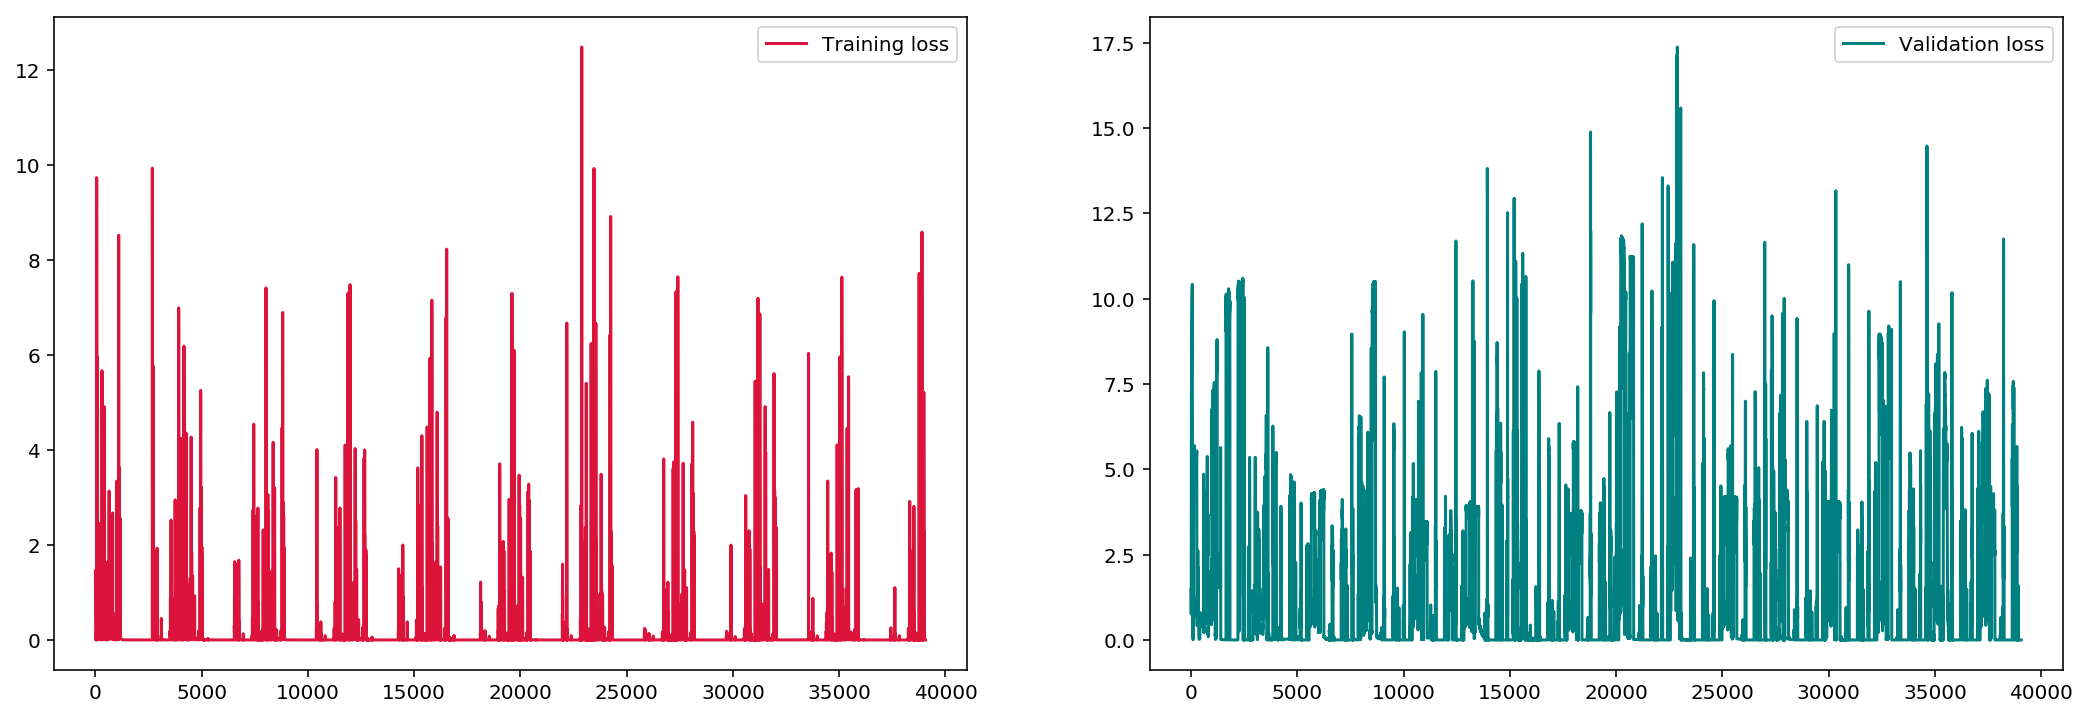

In [141]:
fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

ax1.plot(losses['train'], label='Training loss', color='crimson')
ax2.plot(losses['validation'], label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()

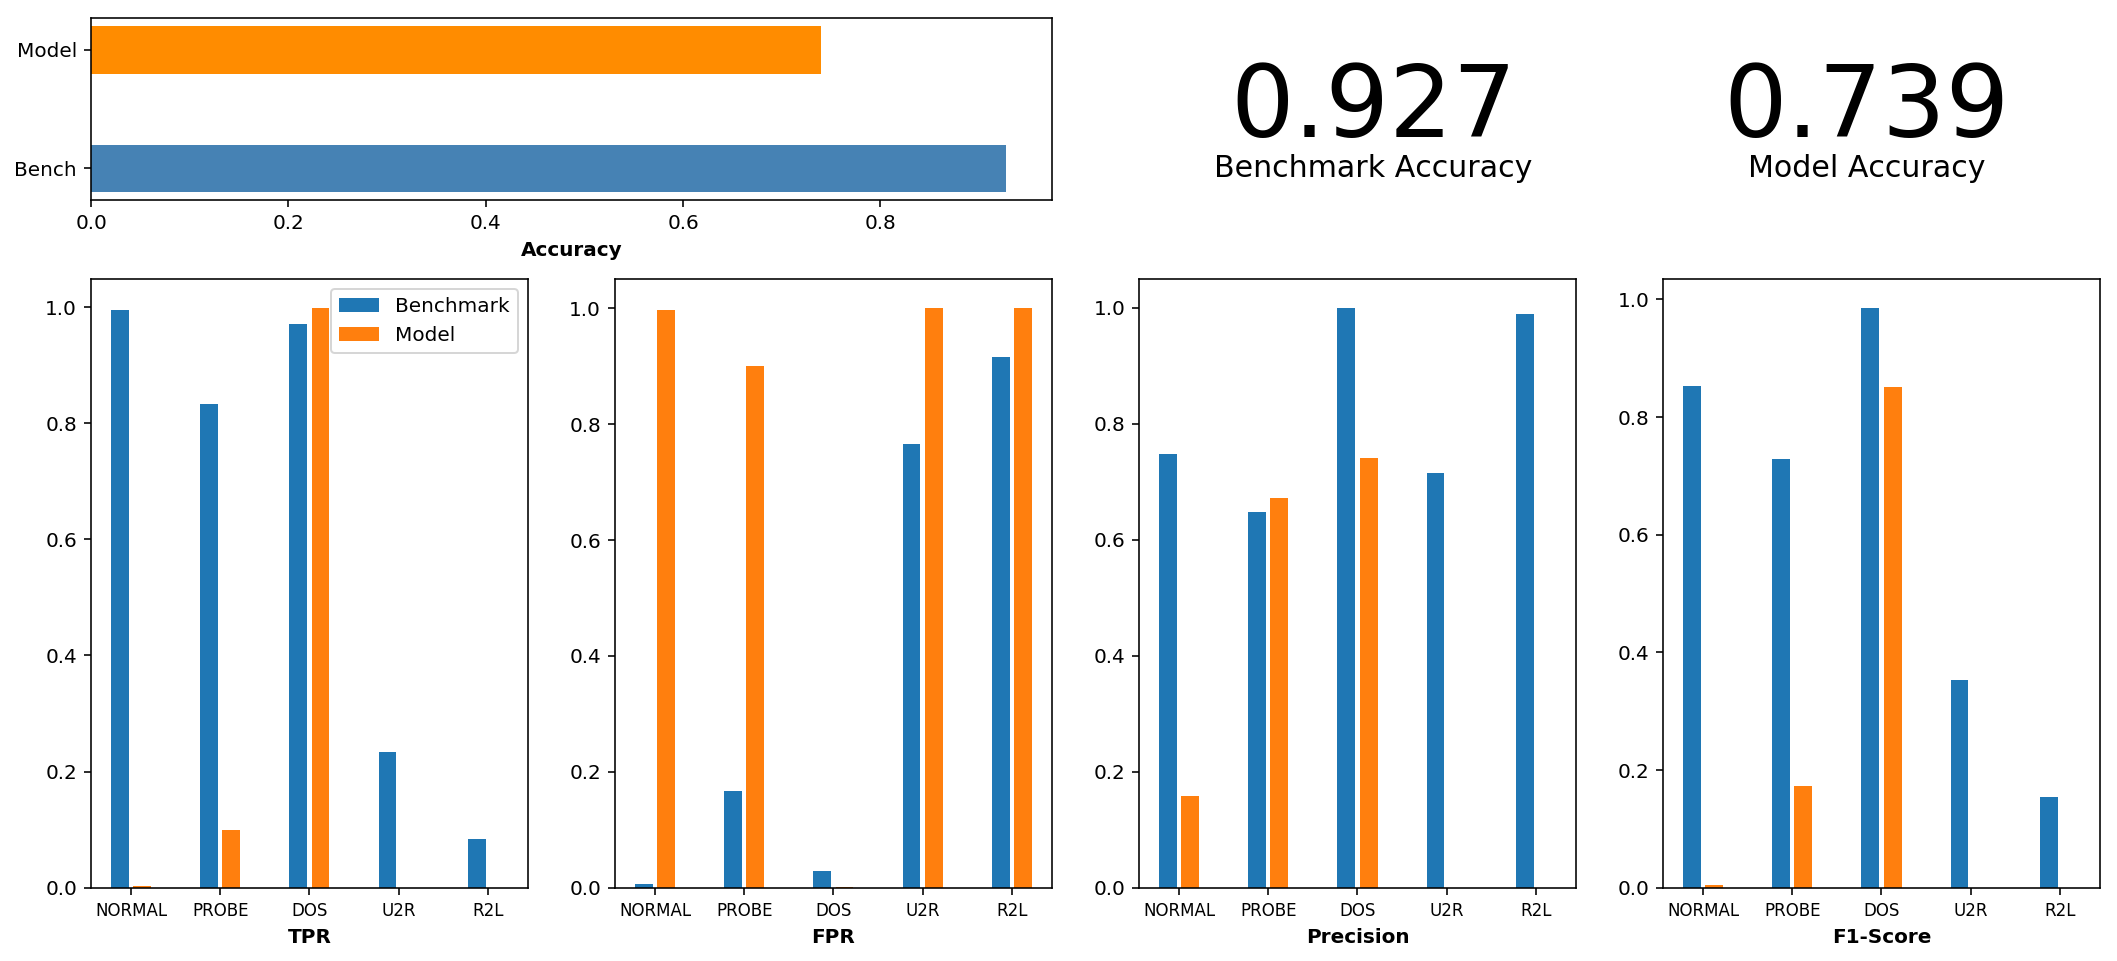

In [142]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
hm.plotMetrics(metrics)